Some files are not included in the repository for privacy reasons.

# Analyzing Creditworthiness in Fintech

Based on the challenge proposed by Kaggle for the detection of clients at risk of defaulting on credit payments, we propose to develop some Machine Learning and Deep Learning models, with the aim of putting into practice the Python fundamentals related to Object-Oriented Programming. To achieve this, the focus was on designing Pipelines, constructing Estimators, and creating Machine Learning Models that can fit within Scikit-Learn Pipelines.

The Pipelines have been designed to internally work with numpy, but their outputs are Pandas DataFrames. In this way, a step called "CustomBackup" is created to provide data to those activities related to Data Science that require Pandas DataFrames.

Kaggle Competition: https://www.kaggle.com/competitions/home-credit-default-risk/overview

# Pipeline 1: LightGBM Predictor

In [1]:
%%time
# main_pipeline.py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from src import data_utils
from pipelines.estimators import (
    CorrectOutliers,
    CustomOrdinalEncoder,
    CustomOneHotEncoder,
    CustomImputer,
    CustomBackup,
    CustomScaler,
    CustomDropna
)
from pipelines.smart_pandas import PandasFeatureUnion
from lightgbm_custom.lgbm_estimators import LGBMPredictor, LGBMFeatureSelector


# app_train, app_test, columns_description = data_utils.get_datasets()
app_train = pd.read_csv("dataset/application_train_aai.csv")
app_test = pd.read_csv("dataset/application_test_aai.csv")
columns_description  = pd.read_csv("dataset/HomeCredit_columns_description.csv")

X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)

dtype_object_info = (X_train.loc[:, (X_train.dtypes == "object").values]
        .apply(lambda x: x.to_frame().drop_duplicates().value_counts(), axis=0)
        .sum())

assert isinstance(dtype_object_info, pd.core.series.Series), "type error"


# Numerical or Datetime features
num_dt_ft = X_train.loc[:, (X_train.dtypes != "object").values].columns.tolist()
# Object type features with two unique categories
two_cat_ft = dtype_object_info[dtype_object_info == 2].index.to_list()
# Object type features with more than two unique categories
plus_two_cat_ft = dtype_object_info[dtype_object_info > 2].index.to_list()


workflow_1 = PandasFeatureUnion([
    ("num_dt_cat", FunctionTransformer(lambda X: X[num_dt_ft].reset_index())),
    ("binary_cat", CustomOrdinalEncoder(two_cat_ft)),
    ("multi_label_cat", CustomOneHotEncoder(plus_two_cat_ft)),
    ])

feature_enginering = Pipeline([
    ("outliers", CorrectOutliers()),
    ("numerical_transformation", workflow_1),
    ("impute_nan", CustomImputer(strategy="median")),
    ("backup", CustomBackup(shutdown=True)),
    ("remove_nan", CustomDropna()),
    ("scale", CustomScaler(scaler=StandardScaler)),
    ])

feature_enginering.fit(X_train)
val_data = feature_enginering.transform(X_val)

params = {
    "objective": "binary",
    "metric": "auc",
    "min_child_samples": 2000,
    "num_leaves": 14,
    "learning_rate": 0.1,
    "random_state": 88,
    "n_jobs": -1,
    "verbose": 0,
}

lightgbm_pipeline = Pipeline([
    ("feature_enginering", feature_enginering),
    ("model", LGBMPredictor(params=params, val_data=val_data, y_val=y_val)),
])

lightgbm_pipeline.fit(X_train, y_train)


Training LightGBM Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	training's auc: 0.791357	valid_1's auc: 0.75453
CPU times: total: 1min 7s
Wall time: 31 s


Pipeline(steps=[('feature_enginering',
                 Pipeline(steps=[('outliers', CorrectOutliers()),
                                 ('numerical_transformation',
                                  PandasFeatureUnion(transformer_list=[('num_dt_cat',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000016D675BD580>)),
                                                                       ('binary_cat',
                                                                        CustomOrdinalEncoder(columns=['NAME_CONTRACT_TYPE',
                                                                                                      'FLAG_OWN_CAR',
                                                                                                      'FLAG_OWN_REALTY',
                                                                                                      'EMERGENCYSTATE_MODE']...
49199                 -0.522724                        1.939808   
49200                 -0.522724                       -0.515515   
49201                 -0.522724                        1.939808   

       WALLSMATERIAL_MODE_Wooden  
0                      -0.132211  
1                      -0.132211  
2                      -0.132211  
3                      -0.132211  
4                      -0.132211  
...                          ...  
49197                  -0.132211  
49198                  -0.132211  
49199                  -0.132211  
49200                  -0.132211  
49201                  -0.132211  

[49202 rows x 242 columns],
                               y_val=9122      0
133133    0
3214      0
124219    1
224022    0
         ..
18787     1
106493    0
26045     0
58869     0
55593     0
Name: TARGET, Length: 49202, dtype: int64))])

## Pipeline 2: MBFs Assembly Model


Assembly model with the following Models:
- Base Model: Logistic Regression
- Shallow Neural Network
- Deep Neural Network

All models are feed with the same data, the features selected are the output of the feature selection process.

The feature selection process is based on the following steps:
- The previous required steps for preprocessing the data
- Training a LightGBM model
- Selecting the features with the highest importance (with score bigger than 0)

After the feature selection process we instanciate the three models that conform the assembly model.

We put the models inside a FeatureUnion pipeline, so we can train the three models at the same time.

If we call this last step the "head" of the MBFs model, we can say that the solution is practical because it has the same interface as a single model, but if we want to optimize the training time a better solution would be to train them in parallel processes.

As we use a FeatureUnion pipeline, we cannot use the final pipeline to make predictions, it's a pipeline only for training.

When the training is finished, we can isolate each model accessing the pipeline attribute `transformer_list` and then the attribute `named_steps` of the pipeline holding each model.

From there, we have a Scikit-Learn Estimator that holds the original model in the attribute `model`.

<br />

One goal of this project was to create a Scikit-Learn pipeline that can be feed it with pandas.DataFrame and return a pandas.DataFrame with the transformation (preserve Type). This was achieved with OOP. We create a class called `PandasFeatureUnion` that inherits from `FeatureUnion`. In this class we override the methods `fit` and `transform` to make them work with pandas.DataFrame.

<br />

The main goal was to create pipeline 3. But in this presentation we are going to show you 3 pipelines, pipeline 1 is the LightGBM model trained for predicting the target variable, pipeline 2 is the LightGBM model trained for feature selection, and pipeline 3 is the MBFs Assembly Model.

<br />

At the end we are going to evaluate each model metrics and compare them.

<br />

In [2]:
%%time
import main_pipeline_4 as mp4
mp4.mbfs_pipeline


Training LGBM Feature Selector Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	training's auc: 0.791357	valid_1's auc: 0.75453
Train shape: (196806, 132)
val shape: (49202, 132)
	  Initializing Logistic Regression

Parameters:  {'random_state': 42, 'C': 0.001}
	  Initializing Shallow NN

Learning rate:  1.8
Number of iterations:  800
	  Initializing Multi Layer NN

Layers dimensions:  [132, 132, 50, 1]
Learning rate:  1.0
Number of iterations:  1600

Training LGBM Feature Selector Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	training's auc: 0.791357	valid_1's auc: 0.75453

Training Logistic Regression Model


Training Shallow Neural Network Model

Number of training examples: 196806
Number of testing examples: 49202
Training set shape: (196806, 132)
Training vector shape: (1, 196806)
Testing set shape: (49202, 132)
Testing vector shape: (1, 49202)

(SNN) Cost 

Pipeline(steps=[('feature_enginering',
                 Pipeline(steps=[('outliers', CorrectOutliers()),
                                 ('numerical_transformation',
                                  PandasFeatureUnion(transformer_list=[('num_dt_cat',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000016D675BD440>)),
                                                                       ('binary_cat',
                                                                        CustomOrdinalEncoder(columns=['NAME_CONTRACT_TYPE',
                                                                                                      'FLAG_OWN_CAR',
                                                                                                      'FLAG_OWN_REALTY',
                                                                                                      'EMERGENCYSTATE_MODE']...
4                      1.913056                       -0.515515  
...                         ...                             ...  
49197                 -0.522724                       -0.515515  
49198                 -0.522724                       -0.515515  
49199                 -0.522724                        1.939808  
49200                 -0.522724                       -0.515515  
49201                 -0.522724                        1.939808  

[49202 rows x 132 columns],
                                                                                                     Y_test=9122      0
133133    0
3214      0
124219    1
224022    0
         ..
18787     1
106493    0
26045     0
58869     0
55593     0
Name: TARGET, Length: 49202, dtype: int64,
                                                                                                     layers_dim=[132,
                                                                                                                 132,
                                                                                                                 50,
                                                                                                                 1],
                                                                                                     learning_rate=1.0,
                                                                                                     num_iterations=1600,
                                                                                                     print_cost=True))]))]))])

# Metrics Conclusion

~Before we start comparing the models of the assembly model, we are going to evaluate the performance of the LightGBM model trained for predicting the target variable.~
In adition we are going to define a threshold for labeling the predictions in the test set.

In [3]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    confusion_matrix,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_roc_auc_score(y_true, prediction_list, labels_list):
    assert len(prediction_list) == len(labels_list), "length error"
    dfs = []
    for preds in prediction_list:
        fpr,tpr,thr = roc_curve(y_true, preds)
        dfs.append(pd.DataFrame(dict(fpr=fpr, tpr=tpr, thr=thr)))
    plt.figure(figsize=(12,8))
    plt.axis([0, 1.01, 0, 1.01])
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), linestyle="--")
    for i, df in enumerate(dfs):
        plt.plot(df["fpr"], df["tpr"], label=labels_list[i])    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show();
    print("ROC AUC Scores:")
    for i, label in enumerate(labels_list):
        score = roc_auc_score(y_true, prediction_list[i])
        print(f"{label}: {score:.4f}")

def obtain_threshold(y_true, y_pred, bias_coef=1.):
    precision_l, recall_l, threshold_l = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
    df_stats = pd.DataFrame({"precision":precision_l,"recall": recall_l,"threshold": (list(threshold_l) + [0.999])})

    # Finding the balanced point
    try:
        balanced_threshold = df_stats.loc[(df_stats["precision"] / df_stats["recall"]) == 1]["threshold"].values[0]
    except:
        aux = df_stats[round(df_stats["precision"] - df_stats["recall"], 4) == 0]
        balanced_threshold = aux.iloc[round(len(aux)//2)]["threshold"]
        
    return balanced_threshold * bias_coef

def precision_recall_curve_plot(y_true, y_pred, label, bias_coef=1.):
    precision_l, recall_l, threshold_l = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
    df_stats = pd.DataFrame({"precision":precision_l,"recall": recall_l,"threshold": (list(threshold_l) + [0.999])})

    # Finding the balanced point
    try:
        balanced_threshold = df_stats.loc[(df_stats["precision"] / df_stats["recall"]) == 1]["threshold"].values[0]
    except:
        aux = df_stats[round(df_stats["precision"] - df_stats["recall"], 4) == 0]
        balanced_threshold = aux.iloc[round(len(aux)/2)]["threshold"]

    # Applying bias 
    threshold = balanced_threshold * bias_coef
    precision = df_stats.iloc[(df_stats["threshold"] - threshold).abs().argsort()[:1]]["precision"].values[0]
    recall = df_stats.iloc[(df_stats["threshold"] - threshold).abs().argsort()[:1]]["recall"].values[0]

    # Precision-Recall Curve Plot
    plt.figure(figsize=(8, 4))
    plt.plot(recall_l, precision_l, label="bias_coef={} | Threshold={:.2f}".format(bias_coef, threshold))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {label}")
    plt.axvline(x=recall, color="k", linewidth=0.5, linestyle="--")
    plt.axhline(y=precision, color="k", linewidth=0.5, linestyle="--")

    plt.text(recall+0.15, precision+0.1, f"({recall:.2f}, {precision:.2f})", fontsize=10, ha='right', va='bottom')
    plt.legend()
    plt.show();
    
def plot_confusion_matrix(y_true, y_pred_proba, label, bias_coef=1.):
    y_pred = (y_pred_proba >= obtain_threshold(y_true, y_pred_proba, bias_coef=bias_coef)).astype(int)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    disp.plot()
    plt.title("Confusion Matrix - {}".format(label))
    plt.show();
    
def prediction_distribution_plot(train_pred, test_pred, val_pred, label, threshold):

    ax1 = pd.Series(train_pred).plot(kind="hist", bins=255, alpha=1)
    ax2 = pd.Series(test_pred).plot(kind="hist", bins=255, alpha=0.8, color="y")
    ax3 = pd.Series(val_pred).plot(kind="hist", bins=255, alpha=0.6, color="r")


    ax3.set_xlabel("Predict probability")
    ax3.set_title(f"{label} predictions distribution")
    ax3.legend(["Train predictions", "Val predictions", "Test predictions"])
    ax3.axvline(x=threshold, color="k", linestyle="--")
    ax3.text(
        threshold + 0.01,
        ax1.get_ylim()[1] * 0.8,
        "Threshold",
        rotation=90,
        verticalalignment="bottom",
        horizontalalignment="left",
        color="k",
        fontsize=10,
    )
    plt.show();
    

In [4]:
# Obtain predictions

# Obtain feature sets
train_features = mp4.feature_selection_pipeline.transform(X_train)
val_features = mp4.feature_selection_pipeline.transform(X_val)
test_features = mp4.feature_selection_pipeline.transform(X_test)

# Obtain models
log_reg = mp4.MBFs.named_transformers["base_model"].named_steps["customlogisticregression"]
snn = mp4.MBFs.named_transformers["snn"].named_steps["shallownnbinaryclassifier"]
mlnn = mp4.MBFs.named_transformers["mlnn"].named_steps["multilayernnbinaryclassifier"]

# LightGBM
train_predict_proba_lgbm = lightgbm_pipeline.predict(X_train)
val_predict_proba_lgbm = lightgbm_pipeline.predict(X_val)
test_predict_proba_lgbm = lightgbm_pipeline.predict(X_test)
# Logistic Regression
train_predict_proba_log_reg = log_reg.predict_proba(train_features)
val_predict_proba_log_reg = log_reg.predict_proba(val_features)
test_predict_proba_log_reg = log_reg.predict_proba(test_features)
# Shallow Neural Network
train_predict_proba_snn = np.squeeze(snn.predict_proba(train_features))
val_predict_proba_snn = np.squeeze(snn.predict_proba(val_features))
test_predict_proba_snn = np.squeeze(snn.predict_proba(test_features))
# Deep Neural Network
train_predict_proba_mlnn = np.squeeze(mlnn.predict_proba(train_features))
val_predict_proba_mlnn = np.squeeze(mlnn.predict_proba(val_features))
test_predict_proba_mlnn = np.squeeze(mlnn.predict_proba(test_features))

Training set ROC AUC Curve


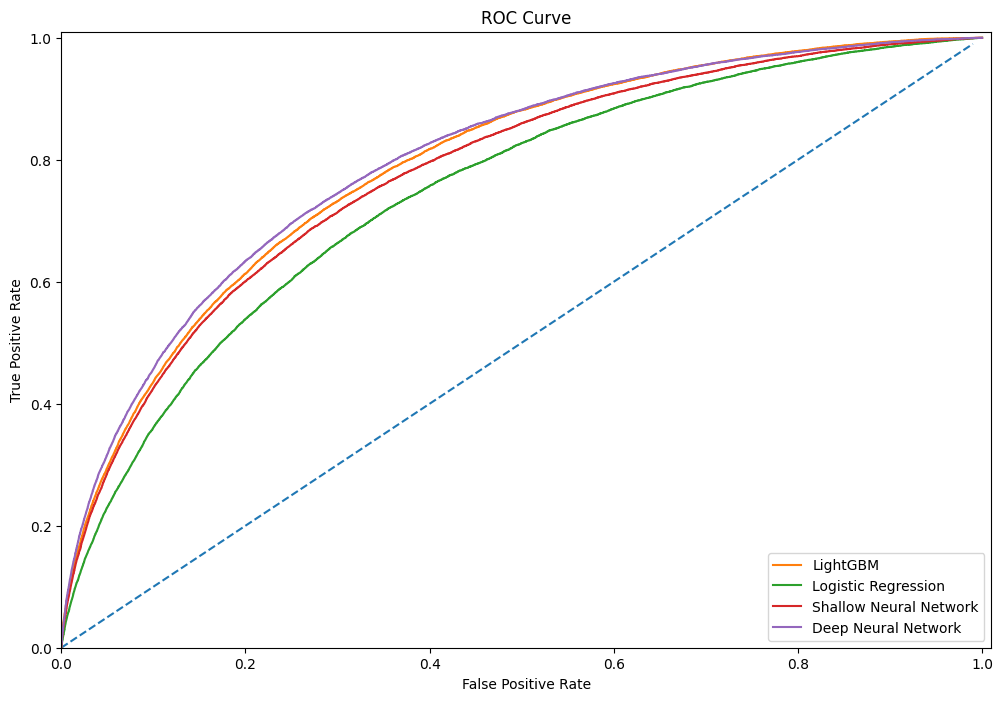

ROC AUC Scores:
LightGBM: 0.7914
Logistic Regression: 0.7456
Shallow Neural Network: 0.7783
Deep Neural Network: 0.7983


Validation set ROC AUC Curve


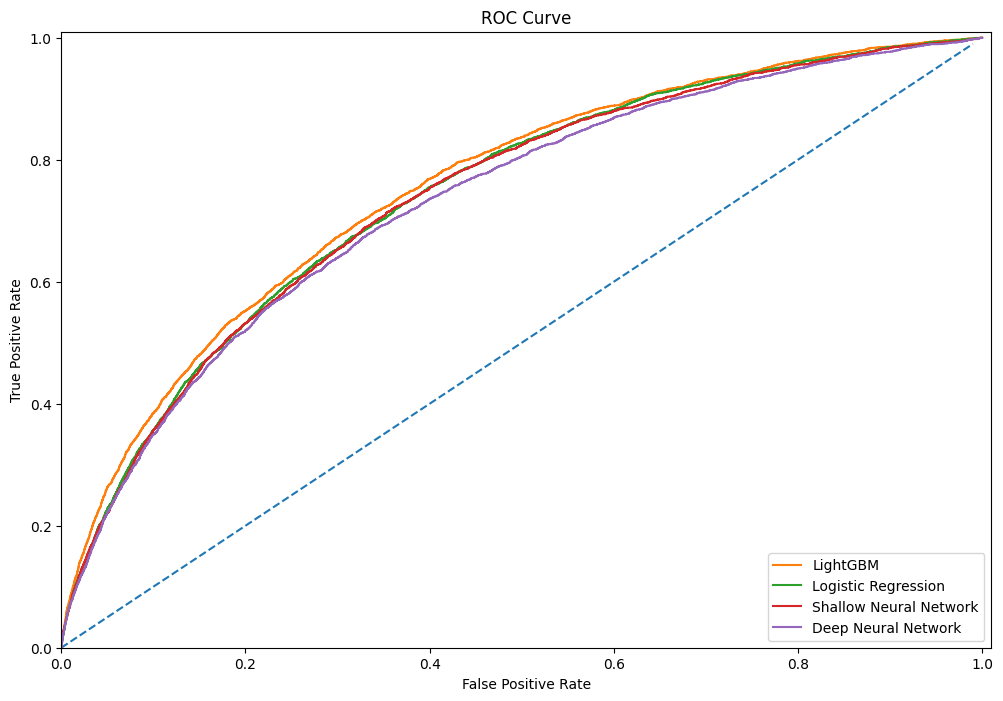

ROC AUC Scores:
LightGBM: 0.7545
Logistic Regression: 0.7433
Shallow Neural Network: 0.7406
Deep Neural Network: 0.7312


In [5]:
# ROC Curve - ROC AUC Score    
labels_list = ["LightGBM", "Logistic Regression", "Shallow Neural Network", "Deep Neural Network"]

print("Training set ROC AUC Curve")
prediction_list = [train_predict_proba_lgbm, train_predict_proba_log_reg, train_predict_proba_snn, train_predict_proba_mlnn]
plot_roc_auc_score(y_train, prediction_list, labels_list)

print("\n\nValidation set ROC AUC Curve")
prediction_list = [val_predict_proba_lgbm, val_predict_proba_log_reg, val_predict_proba_snn, val_predict_proba_mlnn]
plot_roc_auc_score(y_val, prediction_list, labels_list)

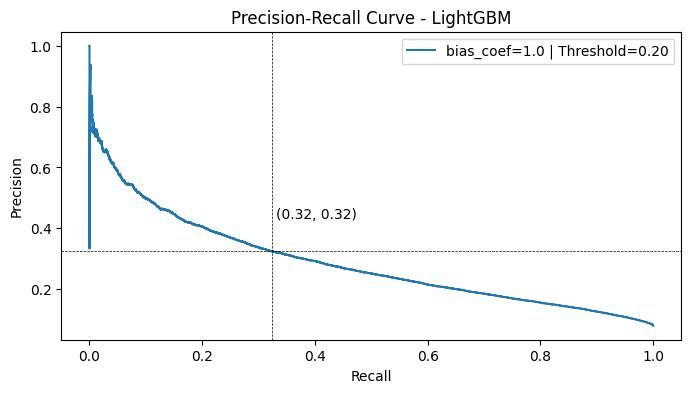

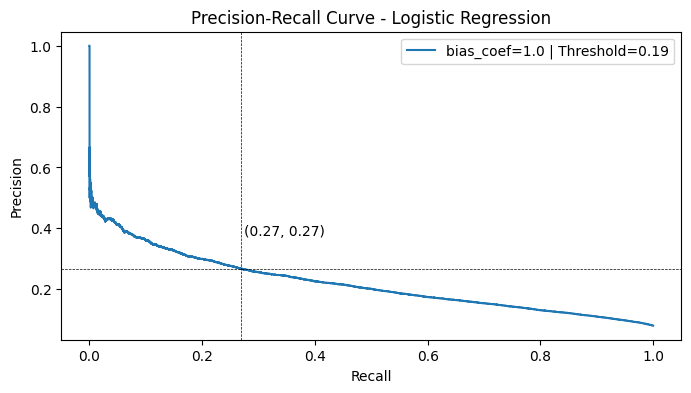

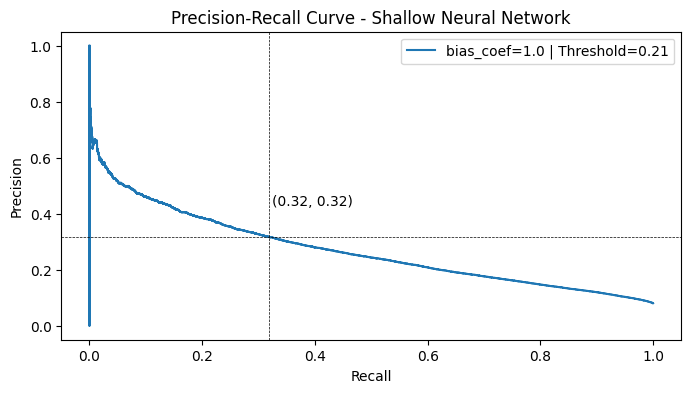

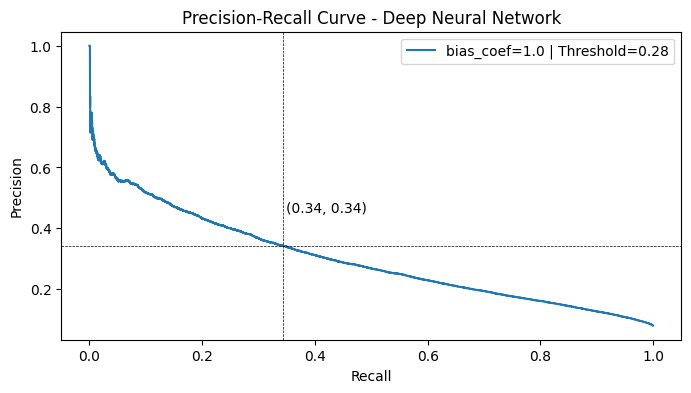

In [6]:
# Metrics: define bias and threshold

precision_recall_curve_plot(y_train, train_predict_proba_lgbm, label="LightGBM")
precision_recall_curve_plot(y_train, train_predict_proba_log_reg, label="Logistic Regression")
precision_recall_curve_plot(y_train, train_predict_proba_snn, label="Shallow Neural Network")
precision_recall_curve_plot(y_train, train_predict_proba_mlnn, label="Deep Neural Network")

Validation set Confusion Matrix


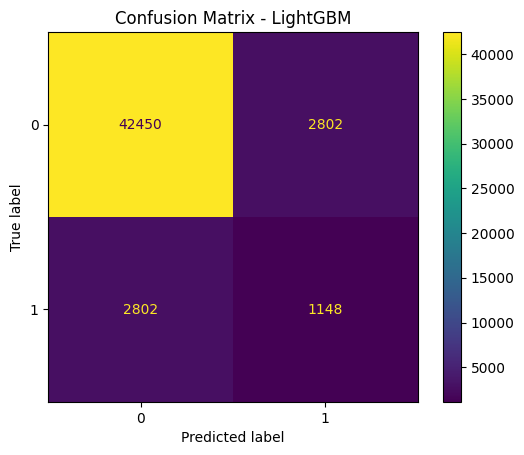

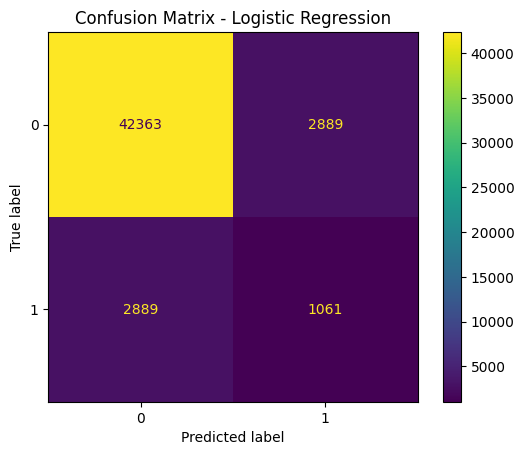

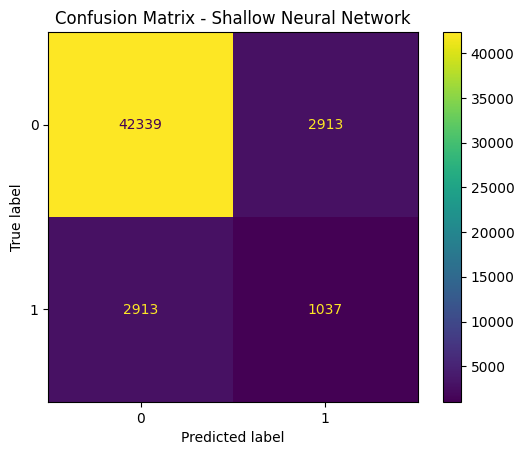

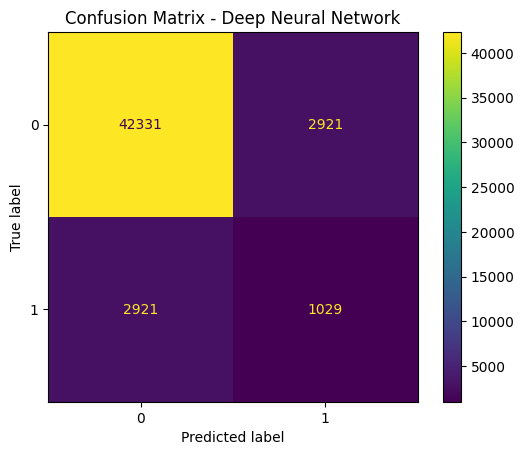

In [7]:
# Confusion Matrix
print("Validation set Confusion Matrix")
   
plot_confusion_matrix(y_val, val_predict_proba_lgbm, label="LightGBM")
plot_confusion_matrix(y_val, val_predict_proba_log_reg, label="Logistic Regression")
plot_confusion_matrix(y_val, val_predict_proba_snn, label="Shallow Neural Network")
plot_confusion_matrix(y_val, val_predict_proba_mlnn, label="Deep Neural Network")

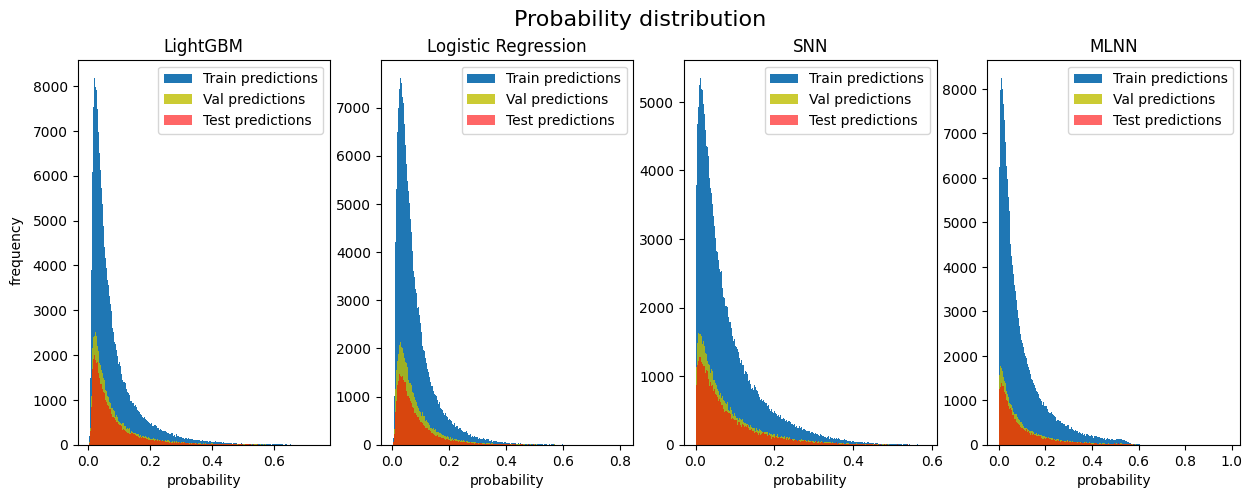

In [8]:
# Histogram of probabilities of each model

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
fig.suptitle("Probability distribution", fontsize=16)

ax[0].set_title("LightGBM")
ax[1].set_title("Logistic Regression")
ax[2].set_title("SNN")
ax[3].set_title("MLNN")
ax[0].set_xlabel("probability")
ax[1].set_xlabel("probability")
ax[2].set_xlabel("probability")
ax[3].set_xlabel("probability")

fig.text(0.08, 0.5, "frequency", va="center", rotation="vertical")


ax[0].hist(train_predict_proba_lgbm, bins=255, alpha=1)
ax[0].hist(test_predict_proba_lgbm, bins=255, alpha=0.8, color="y")
ax[0].hist(val_predict_proba_lgbm, bins=255, alpha=0.6, color="r")
ax[1].hist(train_predict_proba_log_reg, bins=255, alpha=1)
ax[1].hist(test_predict_proba_log_reg, bins=255, alpha=0.8, color="y")
ax[1].hist(val_predict_proba_log_reg, bins=255, alpha=0.6, color="r")
ax[2].hist(train_predict_proba_snn, bins=255, alpha=1)
ax[2].hist(test_predict_proba_snn, bins=255, alpha=0.8, color="y")
ax[2].hist(val_predict_proba_snn, bins=255, alpha=0.6, color="r")
ax[3].hist(train_predict_proba_mlnn, bins=255, alpha=1)
ax[3].hist(test_predict_proba_mlnn, bins=255, alpha=0.8, color="y")
ax[3].hist(val_predict_proba_mlnn, bins=255, alpha=0.6, color="r")

# Add legend
ax[0].legend(["Train predictions", "Val predictions", "Test predictions"])
ax[1].legend(["Train predictions", "Val predictions", "Test predictions"])
ax[2].legend(["Train predictions", "Val predictions", "Test predictions"])
ax[3].legend(["Train predictions", "Val predictions", "Test predictions"]);

Based on the ROC AUC score, the LightGBM model trained for predicting the target variable is the best model.

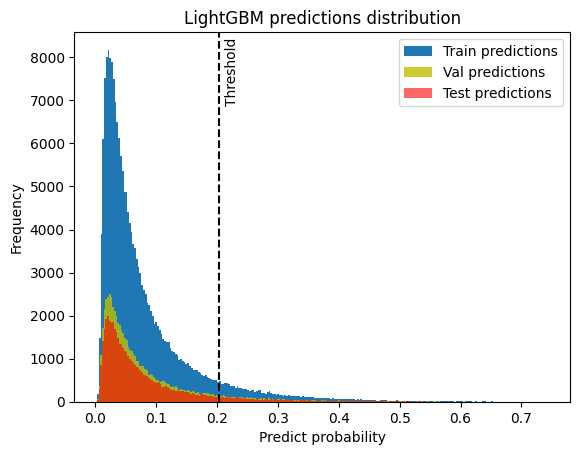

In [9]:
# LightGBM Threshold
threshold = obtain_threshold(y_train, train_predict_proba_lgbm, bias_coef=1.0)

prediction_distribution_plot(train_predict_proba_lgbm,
                             test_predict_proba_lgbm,
                             val_predict_proba_lgbm,
                             label="LightGBM", threshold=threshold)

---

# Technical Conclusions

**Regarding the implementation of "Pipeline_1 LightGBM Predictor", the following conclusions can be drawn:**
- As long as the data structure remains stable, the model can be used in production.
- It provides an end-to-end solution from data reading to prediction.
- Straightforward implementation.
- Good performance in terms of time and accuracy.
- Easy to optimize hyperparameters.

**Regarding the implementation of "Pipeline_2 MBFs Assembly Model", the following conclusions can be drawn:**
- It is a practical solution because it has the same interface as a single model.
- The solution requires previous partial executions to obtain future attributes such as the dimensionality of the selected features.
- It is a solution that runs only on CPU.
- The 3 models in the ensemble run sequentially and not in parallel processes.
- The base models of NN and DNN are formalized as Scikit-Learn estimators.
- Practical methods are created for NN and DNN models (plotting, scoring, etc.).
- It could become an end-to-end solution if a meta-data component is implemented on the local disk.

**Additional clarifications about both models:**
- Prior to training the model, another step "CustomBackup" could be added to obtain the features selected by the feature selection model.
- Implementation of unsupervised clustering models to facilitate data understanding.